In [8]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pixel as pix
import utilities as util
import tile
import importlib
import resnet as rs
import keras
from keras.optimizers import Adam
importlib.reload(tile)

<module 'tile' from '/host/Desktop/cnn_dev/florence_mapping/tile.py'>

In [38]:
landsat, sentinel, dem, label = util.load_data()
tile_size = 10
num_classes = util.get_class_count()
pixel_gen = pix.pixel_gen(landsat, sentinel, dem, label, tile_size, num_classes)
tile_gen = tile.tile_gen(landsat, sentinel, dem, label, tile_size, num_classes)

In [33]:
os.environ["CUDA_VISIBLE_DEVICES"]="3";

In [49]:
pixels = pixel_gen.gen_pixels(100000, balanced=True)
train_px, val_px, test_px = pixel_gen.train_val_test_split(pixels, 0.7, 0.7)
pixel_gen.print_balance()

pixels generated 78914
train:55239 val:16572 test:12075
Water:6019.0
Snow/Ice:0.0
Open Space Developed:6246.0
Low Intensity Developed:0.0
Medium Intensity Developed:6246.0
High Intensity Developed:0.0
Barren Land:6246.0
Deciduous Forest:5468.0
Evergreen Forest:6246.0
Mixed Forest:6008.0
Scrub/Shrub:6246.0
Grassland / Herbaceous:6246.0
Pasture/Hay:5205.0
Cultivated Land:6246.0
Woody Wetland:6246.0
Emergent Herbaceous Wetlands:6246.0


In [68]:
epochs = 100
batch_size = 25
input_shape = tile_gen.get_tile_shape(reshape=True)
print(input_shape)

(10, 10, 10)


In [59]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model

In [60]:
def make_model(in_shape, filters = 128, dense_neurons = 256):
    input_tensor = Input(shape = in_shape)
    
    conv_1 = SeparableConv2D(filters, kernel_size=(2,2), activation='elu') (input_tensor)
    norm_1 = BatchNormalization() (conv_1)
    dropout_1 = Dropout(rate=0.5) (norm_1)
    pool_1 = MaxPooling2D() (dropout_1)
    
    
    conv_2 = SeparableConv2D(filters, kernel_size=(2,2), activation='elu') (pool_1)
    norm_2 = BatchNormalization() (conv_2)
    pool_2 = MaxPooling2D() (norm_2)
    
    #conv_3 = SeparableConv2D(64, kernel_size=(2,2), activation='elu') (pool_2)
    #norm_3 = BatchNormalization() (conv_3)
    #dropout_3 = Dropout(rate=0.5) (norm_3)
    #pool_3 = MaxPooling2D() (dropout_3)

    
    flatten = Flatten() (pool_2)
    dense = Dense(dense_neurons, activation='elu') (flatten)
    output = Dense(num_classes,activation='softmax') (dense)
    model = Model(inputs=input_tensor, outputs=output)
    return model


In [69]:
model = rs.ResnetBuilder.build_resnet_18(input_shape,num_classes)
#model = make_model(input_shape)

In [70]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 10, 10, 10)   0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 5, 5, 64)     31424       input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 5, 5, 64)     256         conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 5, 5, 64)     0           batch_normalization_40[0][0]     
__________________________________________________________________________________________________
max_poolin

In [72]:
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_gen.tile_generator(val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/100
2209/2209 [==============================] - 263s 119ms/step - loss: 2.1768 - acc: 0.3768 - val_loss: 1.9410 - val_acc: 0.4188
Epoch 2/100
2209/2209 [==============================] - 255s 115ms/step - loss: 1.8907 - acc: 0.4229 - val_loss: 1.7850 - val_acc: 0.4468
Epoch 3/100
2209/2209 [==============================] - 255s 115ms/step - loss: 1.7880 - acc: 0.4416 - val_loss: 1.7897 - val_acc: 0.4314
Epoch 4/100
2209/2209 [==============================] - 254s 115ms/step - loss: 1.7277 - acc: 0.4580 - val_loss: 1.7433 - val_acc: 0.4445
Epoch 5/100
2209/2209 [==============================] - 251s 113ms/step - loss: 1.6881 - acc: 0.4669 - val_loss: 1.6836 - val_acc: 0.4673
Epoch 6/100
2209/2209 [==============================] - 252s 114ms/step - loss: 1.6540 - acc: 0.4768 - val_loss: 1.6552 - val_acc: 0.4789
Epoch 7/100
2209/2209 [==============================] - 253s 115ms/step - loss: 1.6300 - acc: 0.4858 - val_loss: 1.6307 - val_acc: 0.4900
Epoch 8/100
2209/2209 [====

2209/2209 [==============================] - 242s 110ms/step - loss: 1.3260 - acc: 0.6475 - val_loss: 2.2400 - val_acc: 0.4562
Epoch 60/100
2209/2209 [==============================] - 244s 110ms/step - loss: 1.3220 - acc: 0.6510 - val_loss: 2.2484 - val_acc: 0.4518
Epoch 61/100
2209/2209 [==============================] - 245s 111ms/step - loss: 1.3231 - acc: 0.6507 - val_loss: 2.2856 - val_acc: 0.4430
Epoch 62/100
2209/2209 [==============================] - 245s 111ms/step - loss: 1.3172 - acc: 0.6530 - val_loss: 2.2870 - val_acc: 0.4524
Epoch 63/100
2209/2209 [==============================] - 245s 111ms/step - loss: 1.3170 - acc: 0.6512 - val_loss: 2.2299 - val_acc: 0.4627
Epoch 64/100
2209/2209 [==============================] - 245s 111ms/step - loss: 1.3142 - acc: 0.6535 - val_loss: 2.2749 - val_acc: 0.4556
Epoch 65/100
2209/2209 [==============================] - 246s 111ms/step - loss: 1.3123 - acc: 0.6555 - val_loss: 2.3145 - val_acc: 0.4580
Epoch 66/100
2209/2209 [=========

In [74]:
model.save('small_cnn.h5')

# Test Pixels

188/188 [==============================] - 40s 214ms/step
Accuracy is 0.42578125


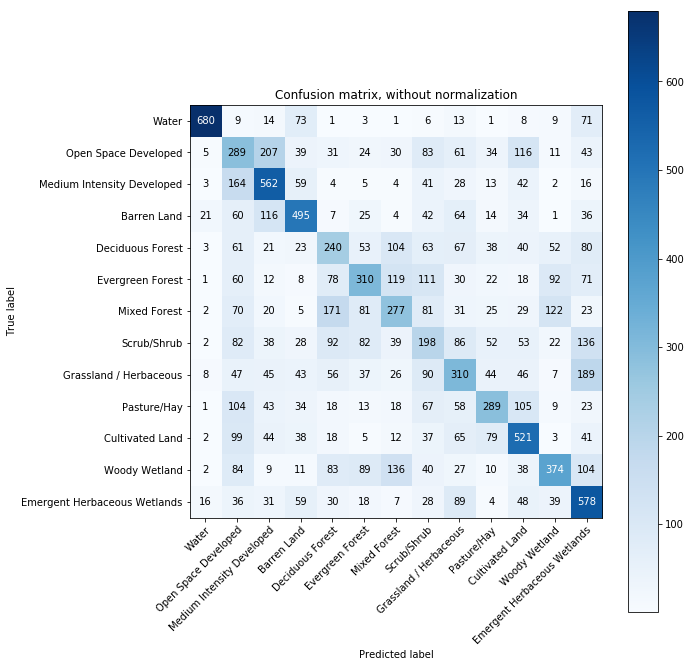

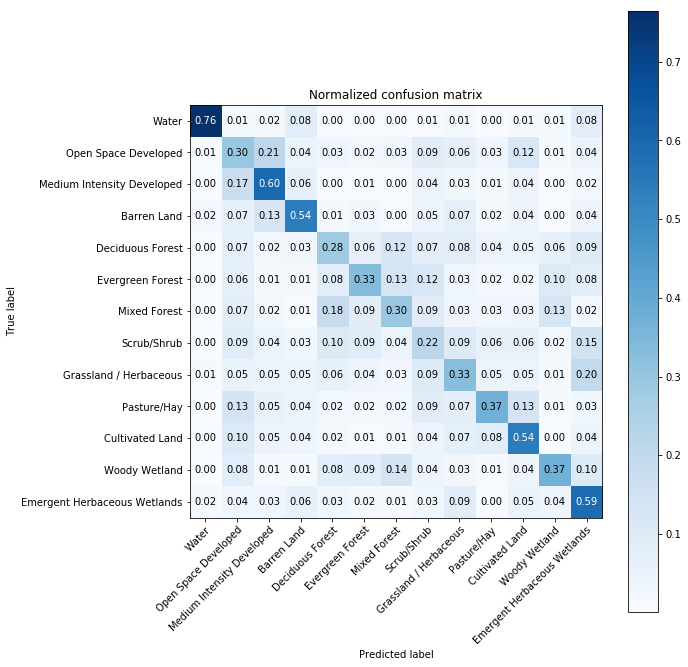

In [75]:
tile_gen.evaluate_cnn(model, test_px)

# Test Pixels on specific tiles

In [76]:
pixel_buckets = { 0: list(), 1: list(), 2: list(), 3: list(), 4: list()}
for pix in test_px:
    pixel_buckets[pix[1]].append(pix)

KeyError: 5

# Tile 0

In [ ]:
tile_gen.evaluate_cnn(model, pixel_buckets[0])

# Tile 1

In [ ]:
tile_gen.evaluate_cnn(model, pixel_buckets[1])

# Tile 2

In [ ]:
tile_gen.evaluate_cnn(model, pixel_buckets[2])

# Tile 3

In [ ]:
tile_gen.evaluate_cnn(model, pixel_buckets[3])

# Tile 4

In [ ]:
tile_gen.evaluate_cnn(model, pixel_buckets[4])